In [41]:
import pandas as pd
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch_geometric.nn import GATConv, SAGEConv
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import itertools
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
# Data Loading and Preprocessing
data_path = "../Data/New_data.csv"
df = pd.read_csv(data_path)
df = df[~df.isin(['x']).any(axis=1)]
print(df.columns)
otu_cols = [col for col in df.columns if "d__" in col]
meta_cols = [col for col in df.columns if col not in otu_cols]

def extract_family_from_colname(colname):
    parts = colname.split(';')
    for part in parts:
        part = part.strip()
        if part.startswith('f__'):
            fam = part[3:]
            return fam if fam else "UnclassifiedFamily"
    return "UnclassifiedFamily"

col_to_family = {}
for c in otu_cols:
    family = extract_family_from_colname(c)
    col_to_family[c] = family

family_to_cols = collections.defaultdict(list)
for c in otu_cols:
    fam = col_to_family[c]
    family_to_cols[fam].append(c)

df_fam = pd.DataFrame(index=df.index)
for fam, col_list in family_to_cols.items():
    df_fam[fam] = df[col_list].sum(axis=1)

param_df = df[meta_cols].copy()
df_fam_rel = df_fam.div(df_fam.sum(axis=1), axis=0)

df_fam_rel.to_csv("family_abundance.csv", index=False)
param_df.to_csv("parameters.csv", index=False)

Index(['Unnamed: 0',
       'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
       'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia',
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella',
       'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Veillonella',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella',
       'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
       'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akker

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_81601/2077128992.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fam[fam] = df[col_list].sum(axis=1)
/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_81601/2077128992.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fam[fam] = df[col_list].sum(axis=1)
/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_81601/2077128992.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [43]:
# Filtering Families
df_fam_rel = pd.read_csv("family_abundance.csv")
param_df = pd.read_csv("parameters.csv")
param_df.columns = param_df.columns.str.strip()

presence_count = (df_fam_rel > 0).sum(axis=0)
prevalence = presence_count / df_fam_rel.shape[0]
prev_threshold = 0.05
high_prev_families = prevalence[prevalence >= prev_threshold].index

mean_abund = df_fam_rel.mean(axis=0)
abund_threshold = 0.01
high_abund_families = mean_abund[mean_abund >= abund_threshold].index

selected_families = high_prev_families.intersection(high_abund_families)
df_fam_rel_filtered = df_fam_rel[selected_families].copy()
print(f"Selected {len(selected_families)} families after filtering.")

Selected 27 families after filtering.


In [44]:
# Constructing Node Features
target_cols = ['ACE-km', 'H2-km']

# Extract targets (graph-level labels)
target_data = param_df[target_cols].copy()

# Remove the target columns from param_inputs if they exist
param_inputs = param_df.drop(columns=target_cols, errors='ignore')

# Double square-root transformation for microbial relative abundances
df_microbe_sqrt = df_fam_rel_filtered.apply(lambda x: np.sqrt(np.sqrt(x)))

# ONLY use microbial features as nodes (no parameter features)
node_features_df = df_microbe_sqrt.copy()
print("Node feature matrix shape (samples x nodes):", node_features_df.shape)

# Record feature names - only microbial features now
node_feature_names = list(node_features_df.columns)
print(f"Number of node features: {len(node_feature_names)}")

Node feature matrix shape (samples x nodes): (54, 27)
Number of node features: 27


In [ ]:
# # Edge Construction via Pearson Correlation 
# # Use only microbial features for edge construction
# corr_matrix = node_features_df.corr()
# corr_threshold = 0.4
# edge_index_list = [[], []]
# num_nodes = len(node_feature_names)
# for i in range(num_nodes):
#     for j in range(i+1, num_nodes):
#         r = corr_matrix.iat[i, j]
#         if abs(r) >= corr_threshold:
#             edge_index_list[0].append(i)
#             edge_index_list[1].append(j)
#             edge_index_list[0].append(j)
#             edge_index_list[1].append(i)
# edge_index = torch.tensor(edge_index_list, dtype=torch.long)
# print("Total edges (undirected) defined by Pearson correlation threshold:", edge_index.shape[1]//2)

Total edges (undirected) defined by Pearson correlation threshold: 113


In [46]:
# Edge Construction via Mantel Test
def compute_distance_matrix(vec, metric='euclidean'):
    if metric == 'euclidean':
        dm = squareform(pdist(vec[:, None], metric='euclidean'))
    elif metric == 'braycurtis':
        dm = squareform(pdist(vec[:, None], metric='braycurtis'))
    else:
        raise ValueError("Unsupported metric.")
    # Replace any NaNs or infs in the computed distance matrix
    dm = np.nan_to_num(dm, nan=0.0, posinf=0.0, neginf=0.0)
    return dm

# Compute distance matrices for each node (feature) - only using microbial features
dist_mats = {}
for col in node_feature_names:
    values = node_features_df[col].values.astype(np.float32)
    # Replace any NaNs or infs with 0
    values = np.nan_to_num(values, nan=0.0, posinf=0.0, neginf=0.0)
    # All columns are microbial features, so use braycurtis distance
    dist_mats[col] = compute_distance_matrix(values, metric='braycurtis')

def mantel_test(dist_matrix1, dist_matrix2, permutations=999):
    n = dist_matrix1.shape[0]
    idx = np.triu_indices(n, k=1)
    d1 = dist_matrix1[idx]
    d2 = dist_matrix2[idx]
    if d1.std() == 0 or d2.std() == 0:
        return 1.0, 0.0
    r_obs = pearsonr(d1, d2)[0]
    count = 0
    for _ in range(permutations):
        perm = np.random.permutation(n)
        d2_perm = dist_matrix2[perm][:, perm]
        r_perm = pearsonr(d1, d2_perm[idx])[0]
        if abs(r_perm) >= abs(r_obs):
            count += 1
    p_val = (count + 1) / (permutations + 1)
    return p_val, r_obs

edge_index_list = [[], []]
num_nodes = len(node_feature_names)
for i, j in itertools.combinations(range(num_nodes), 2):
    col_i = node_feature_names[i]
    col_j = node_feature_names[j]
    p_val, r_val = mantel_test(dist_mats[col_i], dist_mats[col_j], permutations=999)
    if p_val < 0.05:
        edge_index_list[0].extend([i, j])
        edge_index_list[1].extend([j, i])
edge_index = torch.tensor(edge_index_list, dtype=torch.long)
print("Total edges (undirected) defined by Mantel test:", edge_index.shape[1]//2)

Total edges (undirected) defined by Mantel test: 150


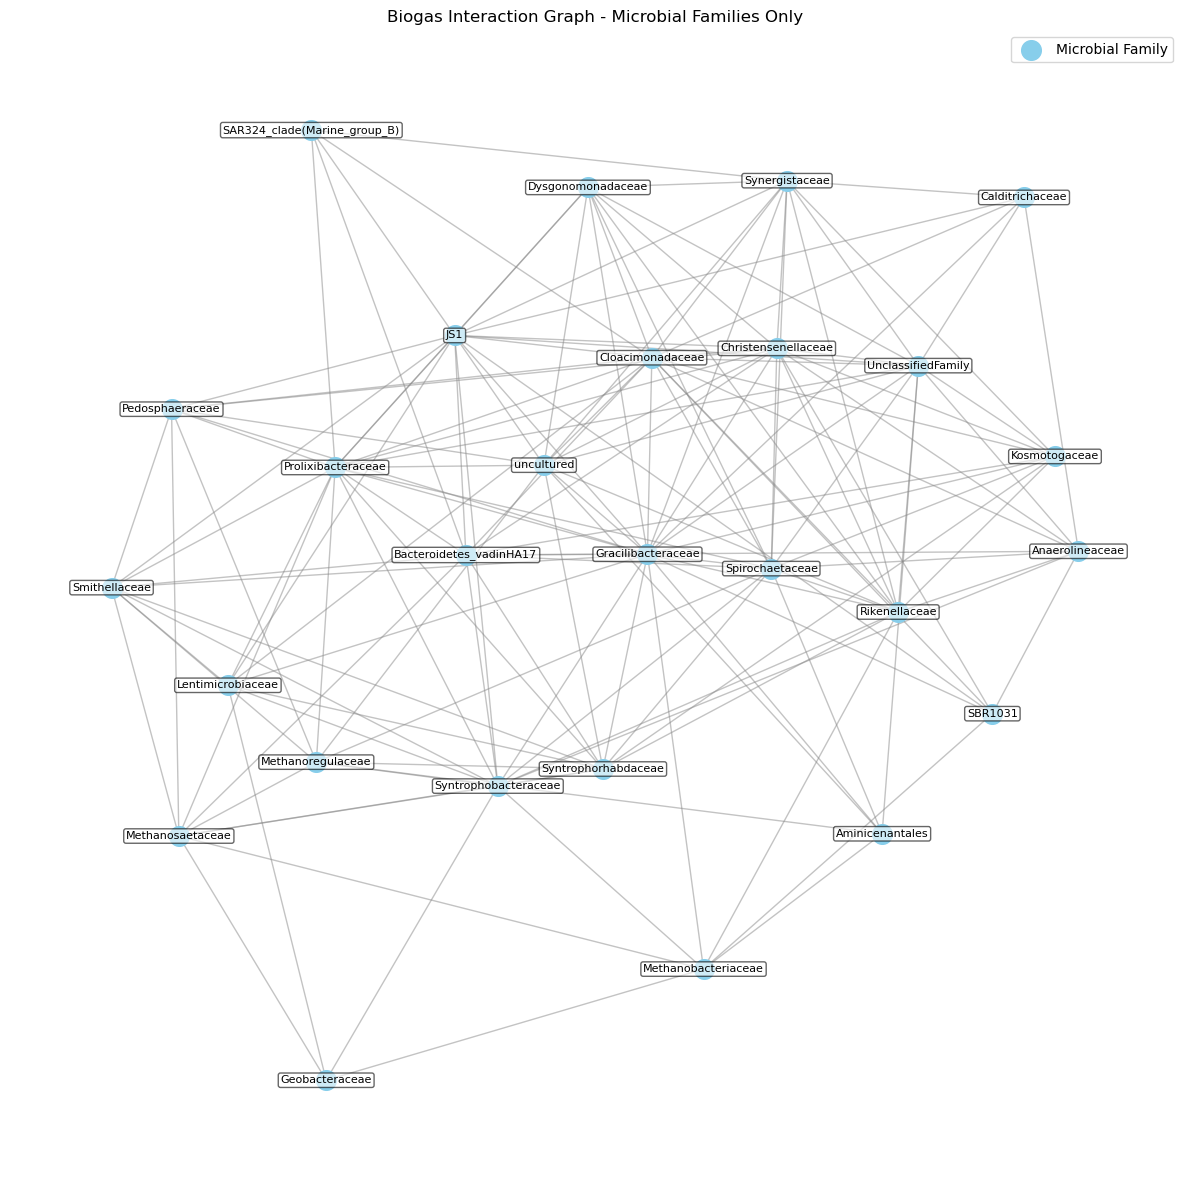

In [47]:
# Graph Visualization with NetworkX

# Graph all the samples
G = nx.Graph()
for i, col in enumerate(node_feature_names):
    G.add_node(col, type='microbe')  # All nodes are now microbial features
    
for src, tgt in zip(edge_index_list[0], edge_index_list[1]):
    G.add_edge(node_feature_names[src], node_feature_names[tgt])
    
# All nodes are now microbe nodes
microbe_nodes = list(G.nodes())

# Use Kamada-Kawai layout for a more balanced view.
pos = nx.kamada_kawai_layout(G)

# Create a larger figure.
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G, pos, edge_color='#888888', alpha=0.5, width=1)

# Draw microbial nodes (blue circles) with smaller sizes.
nx.draw_networkx_nodes(G, pos, nodelist=microbe_nodes, node_color='skyblue', 
                      node_shape='o', node_size=200, label='Microbial Family')

# Label ALL nodes (not just top 15)
labels_dict = {n: n for n in microbe_nodes}
nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

plt.title("Biogas Interaction Graph - Microbial Families Only")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# Create PyG Data Objects for Each Sample
node_features_df = node_features_df.apply(pd.to_numeric, errors='coerce')
print("Node feature matrix shape (samples x nodes):", node_features_df.shape)
node_features = node_features_df.values.astype(np.float32)

# Graph-level target values
target_data = target_data.apply(pd.to_numeric, errors='coerce')

graphs = []
for idx in range(len(node_features_df)):
    # Create node features tensor
    x = torch.tensor(node_features[idx], dtype=torch.float).unsqueeze(1)  # shape: [num_nodes, 1]
    
    # Create graph-level target tensor
    y_vals = target_data.iloc[idx].values.astype(np.float32)
    y = torch.tensor(y_vals, dtype=torch.float).unsqueeze(0)  # shape: [2]
    
    # Create graph with edge_index and graph-level target
    graph = Data(x=x, edge_index=edge_index, y=y)
    graphs.append(graph)

print(f"Created {len(graphs)} graph data objects (one per sample).")
print(f"Each graph has {num_nodes} nodes (microbial families) and {edge_index.shape[1]//2} undirected edges.")
print(f"Target dimensions: {graphs[0].y.shape}")

Node feature matrix shape (samples x nodes): (54, 27)
Created 54 graph data objects (one per sample).
Each graph has 27 nodes (microbial families) and 150 undirected edges.
Target dimensions: torch.Size([1, 2])


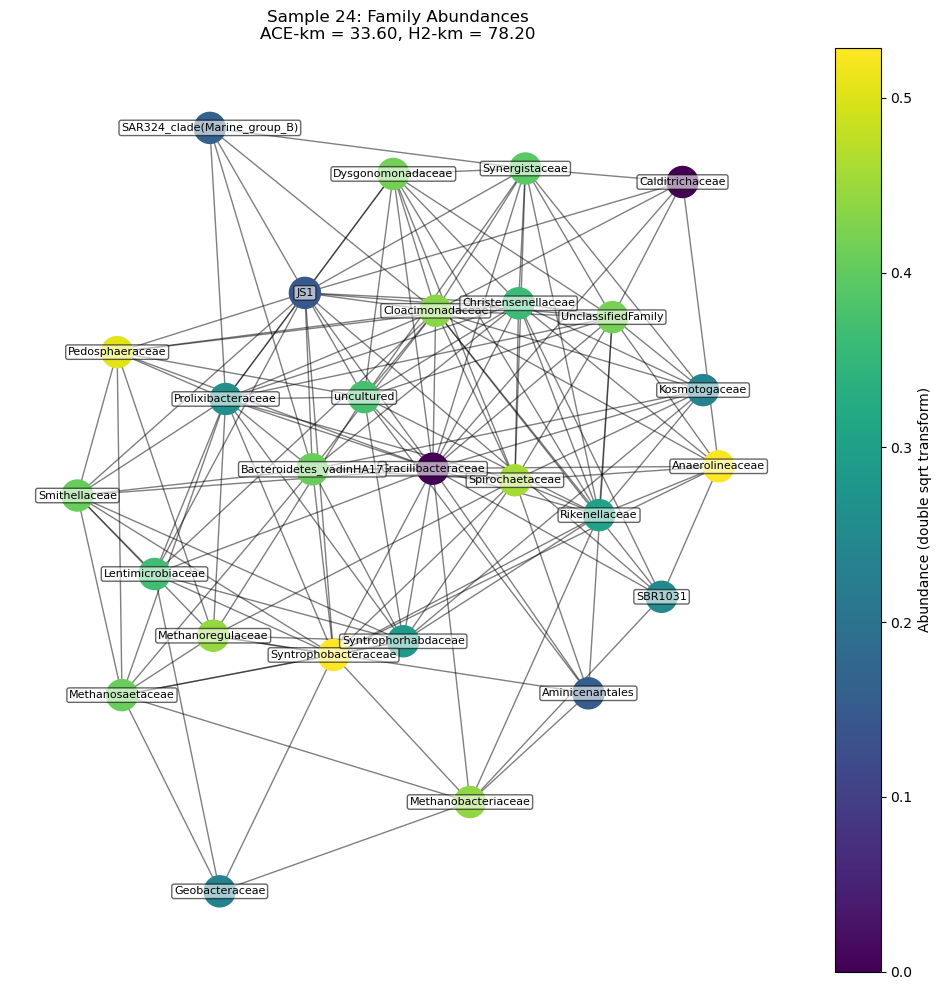

In [70]:
sample_idx = 24
sample = graphs[sample_idx]

# Extract node feature values from the sample
sample_values = sample.x.squeeze().cpu().numpy()

# Create a copy of the static graph G
H = G.copy()

# Annotate each node with the corresponding feature value from the sample
for i, node in enumerate(node_feature_names):
    H.nodes[node]['value'] = sample_values[i]

# Use Kamada–Kawai layout for a balanced view
pos = nx.kamada_kawai_layout(H)

# Draw nodes with color based on the sample's feature value
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(
    H, pos,
    node_color=[H.nodes[n]['value'] for n in H.nodes()],
    cmap=plt.cm.viridis,
    node_size=500
)
nx.draw_networkx_edges(H, pos, alpha=0.5)

# Label ALL nodes, not just the top 15
labels_dict = {n: n for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels_dict, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# Add information about graph-level targets for this sample
target_values = sample.y.cpu().numpy()
# Fix the formatting error by extracting the scalar values properly
ace_km = float(target_values[0, 0])  # Extract the first target as a scalar
h2_km = float(target_values[0, 1])   # Extract the second target as a scalar
plt.title(f"Sample {sample_idx}: Family Abundances\nACE-km = {ace_km:.2f}, H2-km = {h2_km:.2f}")
plt.colorbar(nodes, label="Abundance (double sqrt transform)")
plt.axis('off')
plt.tight_layout()
plt.show()

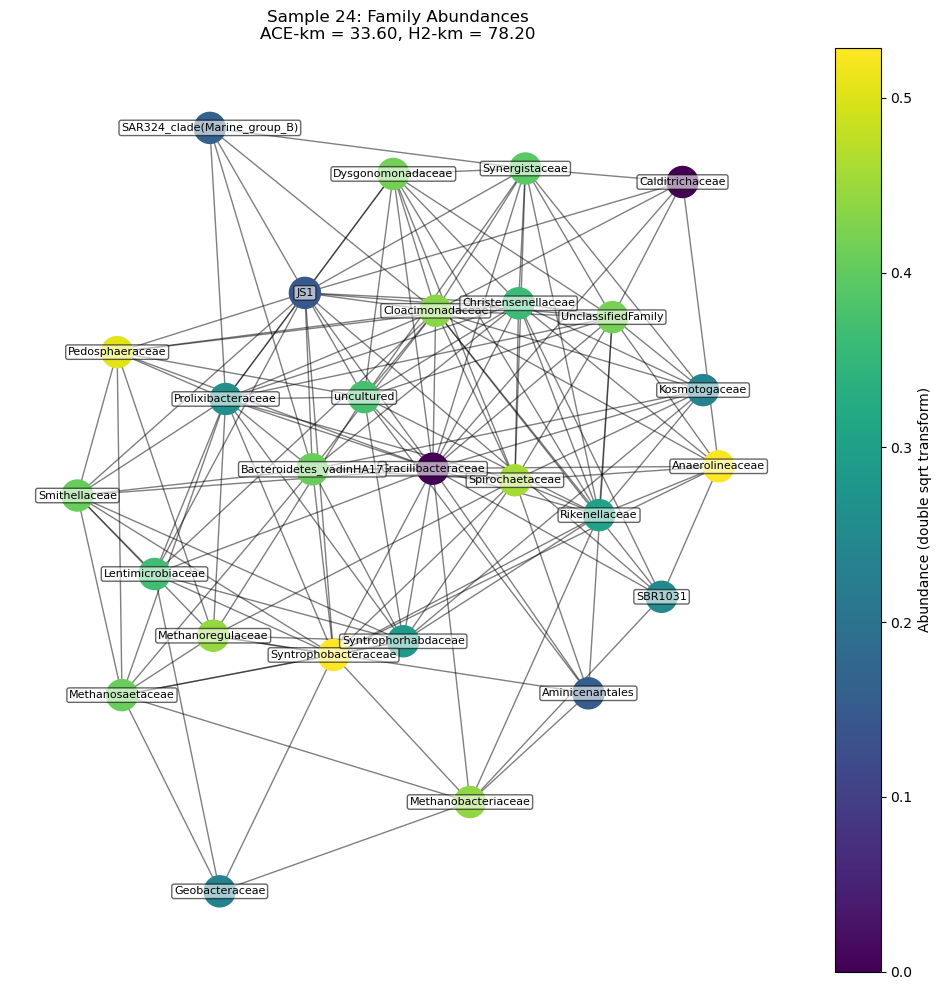

In [74]:
# After loading your sample
sample_idx = 24
sample = graphs[sample_idx]

# IMPORTANT: Get the original edge_index from when the graph was first created
original_edge_index = edge_index  # This should be the global edge_index used to create all graphs

# Create a copy of the ORIGINAL static graph G 
H = nx.Graph()

# Add all nodes first
for i, name in enumerate(node_feature_names):
    H.add_node(name, value=float(sample_values[i]))

# Add ALL edges from the original edge structure
for i in range(original_edge_index.shape[1]):
    src = int(original_edge_index[0, i])
    dst = int(original_edge_index[1, i])
    H.add_edge(node_feature_names[src], node_feature_names[dst])

# Use the same layout algorithm with a fixed seed
random.seed(42)
pos = nx.kamada_kawai_layout(H)

# Draw nodes with color based on the sample's feature value
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(
    H, pos,
    node_color=[H.nodes[n]['value'] for n in H.nodes()],
    cmap=plt.cm.viridis,
    node_size=500
)
nx.draw_networkx_edges(H, pos, alpha=0.5)

# ADD NODE LABELS - labeling all nodes
labels_dict = {n: n for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels_dict, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# ADD COLOR SCALE
plt.colorbar(nodes, label="Abundance (double sqrt transform)")

# ADD TITLE
target_values = sample.y.cpu().numpy()
ace_km = float(target_values[0, 0])
h2_km = float(target_values[0, 1])
plt.title(f"Sample {sample_idx}: Family Abundances\nACE-km = {ace_km:.2f}, H2-km = {h2_km:.2f}")

plt.axis('off')
plt.tight_layout()
plt.show()

In [53]:
# Enhanced GCN Model Definition 
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, hidden_fc=16, out_channels=2):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1   = BatchNorm(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)
        self.bn2   = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.bn3   = BatchNorm(hidden_channels)
        self.fc1   = nn.Linear(hidden_channels, hidden_fc)
        self.fc2   = nn.Linear(hidden_fc, out_channels)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x1 = F.relu(self.conv1(x, edge_index))
        x1 = self.bn1(x1)
        x1 = F.dropout(x1, p=0.3, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index))
        x2 = self.bn2(x2)
        x2 = F.dropout(x2, p=0.3, training=self.training)
        x3 = F.relu(self.conv3(x2, edge_index))
        x3 = self.bn3(x3)
        x3 = x3 + x1  # Residual connection
        x3 = F.dropout(x3, p=0.3, training=self.training)
        graph_feat = global_mean_pool(x3, batch)
        graph_feat = F.relu(self.fc1(graph_feat))
        graph_feat = F.dropout(graph_feat, p=0.3, training=self.training)
        out = self.fc2(graph_feat)
        return out

# class ImprovedGCNModel(nn.Module):
#     def __init__(self, in_channels, hidden_channels=64, hidden_fc=32, out_channels=2, dropout=0.4):
#         super(ImprovedGCNModel, self).__init__()
#         # Increase model capacity with larger hidden dimensions
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.bn1 = BatchNorm(hidden_channels)
#         # Multi-head attention for better feature learning
#         self.conv2 = GATConv(hidden_channels, hidden_channels, heads=3, concat=True)
#         self.bn2 = BatchNorm(hidden_channels * 3)  # 3 heads
#         self.conv3 = SAGEConv(hidden_channels * 3, hidden_channels)
#         self.bn3 = BatchNorm(hidden_channels)
        
#         # Deeper FC layers
#         self.fc1 = nn.Linear(hidden_channels, hidden_fc * 2)
#         self.bn_fc1 = nn.BatchNorm1d(hidden_fc * 2)
#         self.fc2 = nn.Linear(hidden_fc * 2, hidden_fc)
#         self.bn_fc2 = nn.BatchNorm1d(hidden_fc)
#         self.fc3 = nn.Linear(hidden_fc, out_channels)
        
#         self.dropout = dropout
    
#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
        
#         # First GCN layer
#         x1 = F.relu(self.conv1(x, edge_index))
#         x1 = self.bn1(x1)
#         x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
#         # GAT layer with multiple heads
#         x2 = F.relu(self.conv2(x1, edge_index))
#         x2 = self.bn2(x2)
#         x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
#         # SAGE layer
#         x3 = F.relu(self.conv3(x2, edge_index))
#         x3 = self.bn3(x3)
#         x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
#         # Global pooling
#         graph_feat = global_mean_pool(x3, batch)
        
#         # Deeper FC network
#         graph_feat = F.relu(self.fc1(graph_feat))
#         graph_feat = self.bn_fc1(graph_feat)
#         graph_feat = F.dropout(graph_feat, p=self.dropout, training=self.training)
        
#         graph_feat = F.relu(self.fc2(graph_feat))
#         graph_feat = self.bn_fc2(graph_feat)
#         graph_feat = F.dropout(graph_feat, p=self.dropout, training=self.training)
        
#         out = self.fc3(graph_feat)
#         return out

Fold 1 Epoch 020 | Train Loss: 1514.8094
Fold 1 Epoch 040 | Train Loss: 1406.1160
Fold 1 Epoch 060 | Train Loss: 1138.5704
Fold 1 Epoch 080 | Train Loss: 738.1114
Fold 1 Epoch 100 | Train Loss: 447.1493
Fold 1 Epoch 120 | Train Loss: 405.1709
Fold 1 Epoch 140 | Train Loss: 269.2170
Fold 1 Epoch 160 | Train Loss: 357.4500
Fold 1 Epoch 180 | Train Loss: 417.3338
Fold 1 Epoch 200 | Train Loss: 199.3902
Fold 1 completed. Validation samples: 11
Fold 2 Epoch 020 | Train Loss: 1188.7062
Fold 2 Epoch 040 | Train Loss: 1004.0540
Fold 2 Epoch 060 | Train Loss: 625.3999
Fold 2 Epoch 080 | Train Loss: 399.2125
Fold 2 Epoch 100 | Train Loss: 355.9107
Fold 2 Epoch 120 | Train Loss: 389.4140
Fold 2 Epoch 140 | Train Loss: 422.4812
Fold 2 Epoch 160 | Train Loss: 414.1203
Fold 2 Epoch 180 | Train Loss: 426.7003
Fold 2 Epoch 200 | Train Loss: 391.2160
Fold 2 completed. Validation samples: 11
Fold 3 Epoch 020 | Train Loss: 1445.7273
Fold 3 Epoch 040 | Train Loss: 1251.1120
Fold 3 Epoch 060 | Train Loss: 

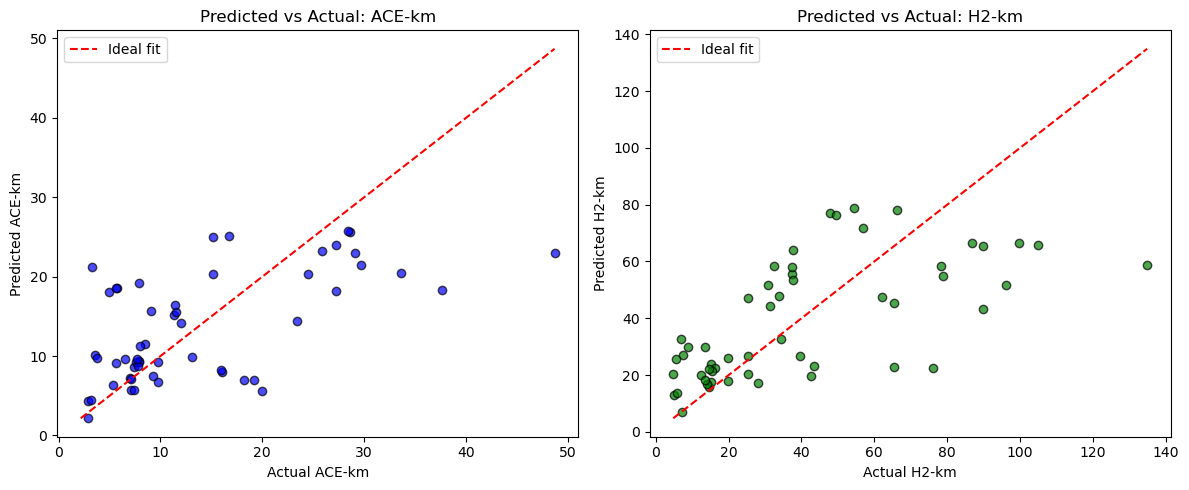

In [55]:
# 5-Fold Cross Validation, Evaluation, and Plotting
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_preds = []
all_fold_trues = []

for train_idx, val_idx in kf.split(graphs):
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs   = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_graphs, batch_size=16, shuffle=False)
    
    model = GCNModel(in_channels=1, hidden_channels=32, hidden_fc=16, out_channels=2).to(device)
    # model = ImprovedGCNModel(in_channels=1, hidden_channels=64, hidden_fc=32, out_channels=2, dropout=0.4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    
    for epoch in range(1, 201):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = loss_fn(pred, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
        if epoch % 20 == 0:
            print(f"Fold {fold} Epoch {epoch:03d} | Train Loss: {total_loss/len(train_graphs):.4f}")
    
    model.eval()
    fold_preds = []
    fold_trues = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            fold_preds.append(pred.cpu().numpy())
            fold_trues.append(batch.y.cpu().numpy())
    fold_preds = np.vstack(fold_preds)
    fold_trues = np.vstack(fold_trues)
    all_fold_preds.append(fold_preds)
    all_fold_trues.append(fold_trues)
    print(f"Fold {fold} completed. Validation samples: {fold_preds.shape[0]}")
    fold += 1

all_preds = np.vstack(all_fold_preds)
all_trues = np.vstack(all_fold_trues)

mse_ace = mean_squared_error(all_trues[:,0], all_preds[:,0])
mse_h2  = mean_squared_error(all_trues[:,1], all_preds[:,1])
r2_ace = r2_score(all_trues[:,0], all_preds[:,0])
r2_h2  = r2_score(all_trues[:,1], all_preds[:,1])
print(f"Overall CV MSE: ACE-km={mse_ace:.4f}, H2-km={mse_h2:.4f}")
print(f"Overall CV R^2: ACE-km={r2_ace:.3f}, H2-km={r2_h2:.3f}")

#%% Plot Predicted vs Actual with Reference Line
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(all_trues[:,0], all_preds[:,0], alpha=0.7, color='blue', edgecolors='k')
min_val = min(all_trues[:,0].min(), all_preds[:,0].min())
max_val = max(all_trues[:,0].max(), all_preds[:,0].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal fit')
plt.xlabel("Actual ACE-km")
plt.ylabel("Predicted ACE-km")
plt.title("Predicted vs Actual: ACE-km")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(all_trues[:,1], all_preds[:,1], alpha=0.7, color='green', edgecolors='k')
min_val = min(all_trues[:,1].min(), all_preds[:,1].min())
max_val = max(all_trues[:,1].max(), all_preds[:,1].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal fit')
plt.xlabel("Actual H2-km")
plt.ylabel("Predicted H2-km")
plt.title("Predicted vs Actual: H2-km")
plt.legend()
plt.tight_layout()
plt.show()

PyTorch Geometric version: 2.6.1
Explaining prediction for Sample 24
Target values: ACE-km = 33.60, H2-km = 78.20

Top 5 most important microbial families for this prediction:
1. Spirochaetaceae (importance: 0.285)
2. Methanosaetaceae (importance: 0.268)
3. Christensenellaceae (importance: 0.260)
4. Rikenellaceae (importance: 0.256)
5. Syntrophobacteraceae (importance: 0.253)

Edge importance statistics:
Min: 0.050, Max: 0.272, Mean: 0.093


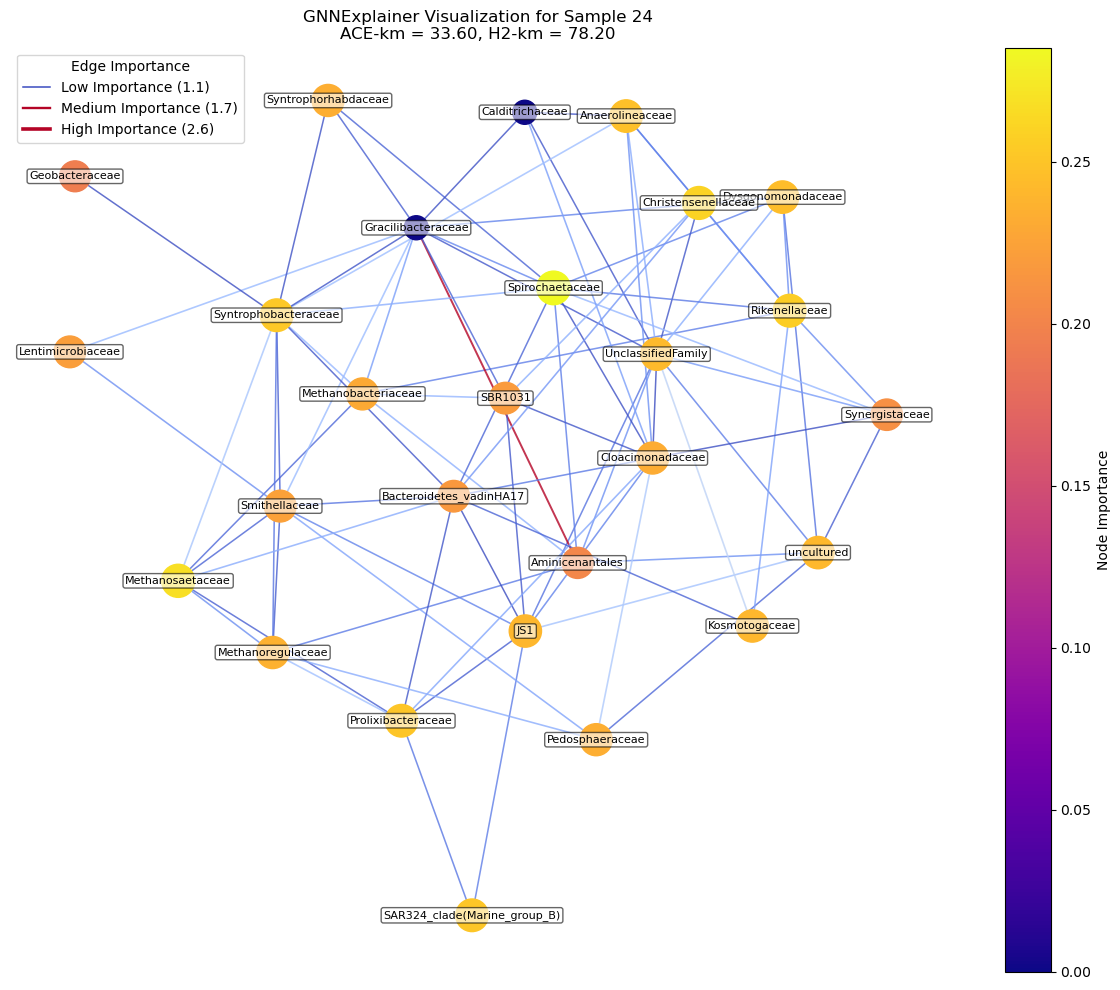

                Microbial_Family  Importance
6                Spirochaetaceae    0.285175
19              Methanosaetaceae    0.267704
20           Christensenellaceae    0.259804
5                  Rikenellaceae    0.255989
12          Syntrophobacteraceae    0.252761
11  SAR324_clade(Marine_group_B)    0.251739
18            Prolixibacteraceae    0.250323
13               Anaerolineaceae    0.246249
1              Dysgonomonadaceae    0.244224
3             UnclassifiedFamily    0.242136


In [61]:
import torch_geometric
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

from torch_geometric.explain import GNNExplainer, Explainer
import torch.nn as nn
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Create a wrapper for your model to make it compatible with the explainer
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x, edge_index, batch=None):
        # Create a Data-like object that your model expects
        class DataContainer:
            pass
        
        data = DataContainer()
        data.x = x
        data.edge_index = edge_index
        data.batch = batch
        
        return self.model(data)

# Wrap your model
model.eval()
wrapped_model = ModelWrapper(model)

sample_idx = 24
sample = graphs[sample_idx].to(device)

# Create a batch tensor (since we're only explaining one sample)
if sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=device)

# Important: Make sure tensors require grad for the explainer
x = sample.x.clone().detach().requires_grad_(True)
edge_index = sample.edge_index.clone().detach()

# Create the explainer using the wrapped model
algorithm = GNNExplainer(epochs=200)
explainer = Explainer(
    model=wrapped_model,  # Use the wrapped model
    algorithm=algorithm,
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    )
)

# Generate the explanation WITHOUT torch.no_grad() since explainer needs gradients
explanation = explainer(x, edge_index, batch=sample.batch)
node_feat_mask = explanation.node_mask
edge_mask = explanation.edge_mask

print(f"Explaining prediction for Sample {sample_idx}")
print(f"Target values: ACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")

# Print the top 5 most important nodes
node_importance = node_feat_mask.squeeze().cpu().numpy()
top_node_indices = node_importance.argsort()[-5:][::-1]
print("\nTop 5 most important microbial families for this prediction:")
for i, idx in enumerate(top_node_indices):
    print(f"{i+1}. {node_feature_names[idx]} (importance: {node_importance[idx]:.3f})")

# Create a customized visualization using networkx
plt.figure(figsize=(12, 10))
edge_mask_np = edge_mask.cpu().detach().numpy()

# Print edge importance statistics
edge_importances = []
for i in range(edge_mask.shape[0]):
    edge_importances.append(float(edge_mask_np[i]))

print("\nEdge importance statistics:")
print(f"Min: {min(edge_importances):.3f}, Max: {max(edge_importances):.3f}, Mean: {sum(edge_importances)/len(edge_importances):.3f}")

# Create a graph for this specific explanation
G_custom = nx.Graph()
for i, name in enumerate(node_feature_names):
    G_custom.add_node(name, importance=float(node_feat_mask[i].cpu()))

# Add edges with weights from edge_mask
for i in range(edge_mask.shape[0]):
    src = int(sample.edge_index[0, i].cpu())
    dst = int(sample.edge_index[1, i].cpu())
    if edge_mask_np[i] > 0.1:  # Only include edges with some importance
        G_custom.add_edge(node_feature_names[src], node_feature_names[dst], 
                         weight=float(edge_mask_np[i]))

# Position nodes using the layout from previous visualizations
pos = nx.kamada_kawai_layout(G_custom)

# CHANGED: Use a colormap for edge colors based on importance
edge_weights = [G_custom[u][v]['weight'] for u, v in G_custom.edges()]
edge_widths = [0.8 + G_custom[u][v]['weight'] * 3 for u, v in G_custom.edges()]

# Create a colormap for edges
edge_cmap = plt.cm.coolwarm  # Use a colormap that transitions from cool to warm colors
edge_norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [edge_cmap(edge_norm(weight)) for weight in edge_weights]

# Draw edges with varying width and color based on importance
for i, (u, v) in enumerate(G_custom.edges()):
    nx.draw_networkx_edges(G_custom, pos, edgelist=[(u, v)], 
                          width=edge_widths[i], 
                          edge_color=[edge_colors[i]], 
                          alpha=0.8)

# Node size and color based on importance
node_sizes = [300 + 1000 * G_custom.nodes[n]['importance'] for n in G_custom.nodes()]
node_colors = [G_custom.nodes[n]['importance'] for n in G_custom.nodes()]

# Draw nodes
nodes = nx.draw_networkx_nodes(G_custom, pos, node_size=node_sizes, 
                              node_color=node_colors, cmap=plt.cm.plasma)

# Add labels to all nodes
nx.draw_networkx_labels(G_custom, pos, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# ADDED: Better Legend for edge colors and thickness
# Create custom legend with both width and color
import matplotlib.lines as mlines
handles = []
cmap = edge_cmap
norm = edge_norm

# Create importance categories
importance_levels = [0.1, 0.3, 0.6]
importance_labels = ['Low', 'Medium', 'High']
for i, (imp, label) in enumerate(zip(importance_levels, importance_labels)):
    width = 0.8 + imp * 3
    color = cmap(norm(imp))
    # Use Line2D for custom line legend entries
    handles.append(mlines.Line2D([], [], color=color, linewidth=width, 
                                label=f'{label} Importance ({width:.1f})'))

plt.legend(handles=handles, title="Edge Importance", loc='upper left')

plt.colorbar(nodes, label="Node Importance")
plt.title(f"GNNExplainer Visualization for Sample {sample_idx}\nACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the explanation results if needed
import pandas as pd
importance_df = pd.DataFrame({
    'Microbial_Family': node_feature_names,
    'Importance': node_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df.head(10))  # Print top 10 important features

PyTorch Geometric version: 2.6.1
Explaining prediction for Sample 24
Target values: ACE-km = 33.60, H2-km = 78.20

Top 5 most important microbial families for this prediction:
1. uncultured (importance: 0.302)
2. Prolixibacteraceae (importance: 0.287)
3. Christensenellaceae (importance: 0.279)
4. Spirochaetaceae (importance: 0.271)
5. UnclassifiedFamily (importance: 0.263)

Edge importance statistics:
Min: 0.041, Max: 0.219, Mean: 0.093


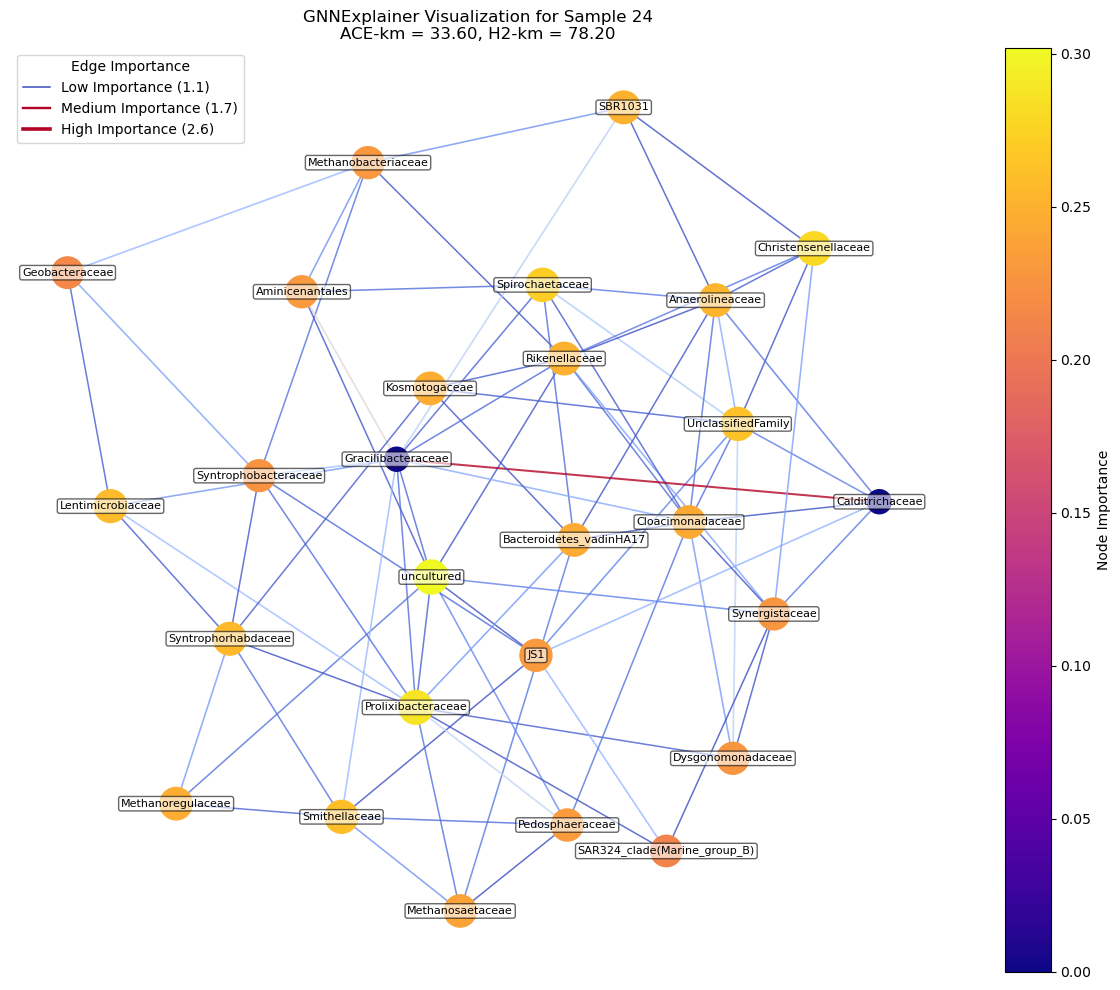

       Microbial_Family  Importance
2            uncultured    0.301921
18   Prolixibacteraceae    0.287366
20  Christensenellaceae    0.278795
6       Spirochaetaceae    0.271163
3    UnclassifiedFamily    0.262840
10        Smithellaceae    0.260463
8     Lentimicrobiaceae    0.257487
16  Syntrophorhabdaceae    0.255734
13      Anaerolineaceae    0.251734
23              SBR1031    0.250263


In [64]:
import torch_geometric
import torch
import numpy as np
import random
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

from torch_geometric.explain import GNNExplainer, Explainer
import torch.nn as nn
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set all random seeds for reproducibility
seed = 54
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a wrapper for your model to make it compatible with the explainer
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x, edge_index, batch=None):
        # Create a Data-like object that your model expects
        class DataContainer:
            pass
        
        data = DataContainer()
        data.x = x
        data.edge_index = edge_index
        data.batch = batch
        
        return self.model(data)

# Wrap your model and ensure it's in eval mode
model.eval()
# Disable dropout for consistency
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0
wrapped_model = ModelWrapper(model)

sample_idx = 24
sample = graphs[sample_idx].to(device)

# Create a batch tensor (since we're only explaining one sample)
if sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=device)

# Important: Make sure tensors require grad for the explainer
x = sample.x.clone().detach().requires_grad_(True)
edge_index = sample.edge_index.clone().detach()

# Create the explainer with deterministic settings
torch.manual_seed(seed)  # Set seed again before creating explainer
algorithm = GNNExplainer(epochs=200)
explainer = Explainer(
    model=wrapped_model,  # Use the wrapped model
    algorithm=algorithm,
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    )
)

# Generate the explanation WITH deterministic settings
torch.manual_seed(seed)  # Set seed again before explanation
explanation = explainer(x, edge_index, batch=sample.batch)
node_feat_mask = explanation.node_mask
edge_mask = explanation.edge_mask

print(f"Explaining prediction for Sample {sample_idx}")
print(f"Target values: ACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")

# Print the top 5 most important nodes
node_importance = node_feat_mask.squeeze().cpu().numpy()
top_node_indices = node_importance.argsort()[-5:][::-1]
print("\nTop 5 most important microbial families for this prediction:")
for i, idx in enumerate(top_node_indices):
    print(f"{i+1}. {node_feature_names[idx]} (importance: {node_importance[idx]:.3f})")

# Create a customized visualization using networkx
plt.figure(figsize=(12, 10))
edge_mask_np = edge_mask.cpu().detach().numpy()

# Print edge importance statistics
edge_importances = []
for i in range(edge_mask.shape[0]):
    edge_importances.append(float(edge_mask_np[i]))

print("\nEdge importance statistics:")
print(f"Min: {min(edge_importances):.3f}, Max: {max(edge_importances):.3f}, Mean: {sum(edge_importances)/len(edge_importances):.3f}")

# Create a graph for this specific explanation
G_custom = nx.Graph()
for i, name in enumerate(node_feature_names):
    G_custom.add_node(name, importance=float(node_feat_mask[i].cpu()))

# Add edges with weights from edge_mask
for i in range(edge_mask.shape[0]):
    src = int(sample.edge_index[0, i].cpu())
    dst = int(sample.edge_index[1, i].cpu())
    if edge_mask_np[i] > 0.1:  # Only include edges with some importance
        G_custom.add_edge(node_feature_names[src], node_feature_names[dst], 
                         weight=float(edge_mask_np[i]))

# Fix the layout seed for consistent node positioning
nx.set_node_attributes(G_custom, pos, 'pos')
random.seed(seed)  # Set seed for layout algorithm
pos = nx.kamada_kawai_layout(G_custom, pos=nx.get_node_attributes(G_custom, 'pos'))

# CHANGED: Use a colormap for edge colors based on importance
edge_weights = [G_custom[u][v]['weight'] for u, v in G_custom.edges()]
edge_widths = [0.8 + G_custom[u][v]['weight'] * 3 for u, v in G_custom.edges()]

# Create a colormap for edges
edge_cmap = plt.cm.coolwarm  # Use a colormap that transitions from cool to warm colors
edge_norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [edge_cmap(edge_norm(weight)) for weight in edge_weights]

# Draw edges with varying width and color based on importance
for i, (u, v) in enumerate(G_custom.edges()):
    nx.draw_networkx_edges(G_custom, pos, edgelist=[(u, v)], 
                          width=edge_widths[i], 
                          edge_color=[edge_colors[i]], 
                          alpha=0.8)

# Node size and color based on importance
node_sizes = [300 + 1000 * G_custom.nodes[n]['importance'] for n in G_custom.nodes()]
node_colors = [G_custom.nodes[n]['importance'] for n in G_custom.nodes()]

# Draw nodes
nodes = nx.draw_networkx_nodes(G_custom, pos, node_size=node_sizes, 
                              node_color=node_colors, cmap=plt.cm.plasma)

# Add labels to all nodes
nx.draw_networkx_labels(G_custom, pos, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# ADDED: Better Legend for edge colors and thickness
# Create custom legend with both width and color
import matplotlib.lines as mlines
handles = []
cmap = edge_cmap
norm = edge_norm

# Create importance categories
importance_levels = [0.1, 0.3, 0.6]
importance_labels = ['Low', 'Medium', 'High']
for i, (imp, label) in enumerate(zip(importance_levels, importance_labels)):
    width = 0.8 + imp * 3
    color = cmap(norm(imp))
    # Use Line2D for custom line legend entries
    handles.append(mlines.Line2D([], [], color=color, linewidth=width, 
                                label=f'{label} Importance ({width:.1f})'))

plt.legend(handles=handles, title="Edge Importance", loc='upper left')

plt.colorbar(nodes, label="Node Importance")
plt.title(f"GNNExplainer Visualization for Sample {sample_idx}\nACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the explanation results if needed
import pandas as pd
importance_df = pd.DataFrame({
    'Microbial_Family': node_feature_names,
    'Importance': node_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df.head(10))  # Print top 10 important features

# Optional: Save explanation results to file for future use
torch.save({
    'node_importance': node_feat_mask,
    'edge_mask': edge_mask,
    'sample_idx': sample_idx
}, f'gnnexplainer_results_sample_{sample_idx}.pt')

PyTorch Geometric version: 2.6.1
Explaining prediction for Sample 24
Target values: ACE-km = 33.60, H2-km = 78.20

Top 5 most important microbial families for this prediction:
1. Cloacimonadaceae (importance: 0.279)
2. Dysgonomonadaceae (importance: 0.271)
3. uncultured (importance: 0.266)
4. Methanobacteriaceae (importance: 0.259)
5. Spirochaetaceae (importance: 0.252)


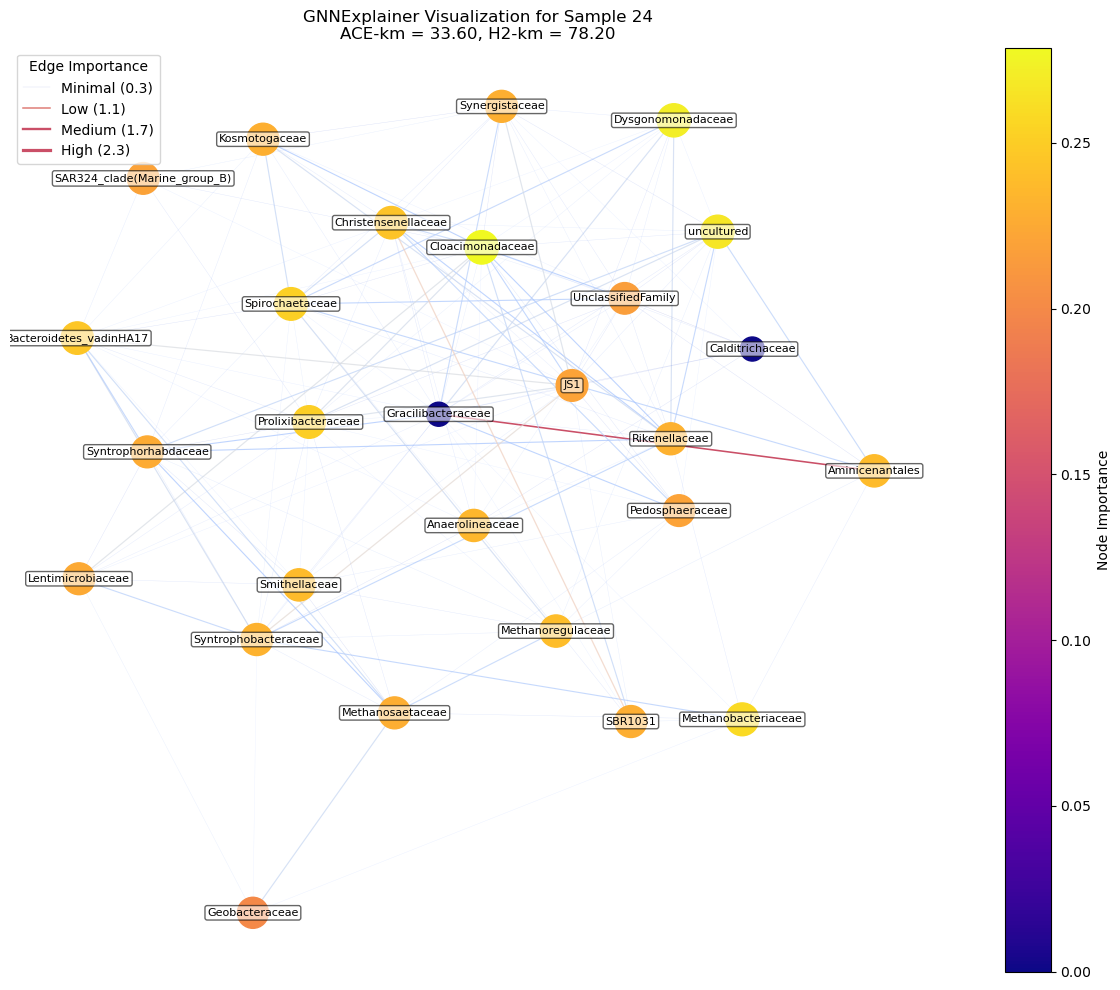

           Microbial_Family  Importance
9          Cloacimonadaceae    0.278707
1         Dysgonomonadaceae    0.271091
2                uncultured    0.265702
0       Methanobacteriaceae    0.258521
6           Spirochaetaceae    0.251605
18       Prolixibacteraceae    0.250504
15  Bacteroidetes_vadinHA17    0.245127
20      Christensenellaceae    0.243738
21        Methanoregulaceae    0.238767
10            Smithellaceae    0.238202


In [75]:
import torch_geometric
import torch
import numpy as np
import random
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

from torch_geometric.explain import GNNExplainer, Explainer
import torch.nn as nn
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set all random seeds for reproducibility
seed = 42  # Use the same seed as the sample visualization
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a wrapper for your model to make it compatible with the explainer
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x, edge_index, batch=None):
        # Create a Data-like object that your model expects
        class DataContainer:
            pass
        
        data = DataContainer()
        data.x = x
        data.edge_index = edge_index
        data.batch = batch
        
        return self.model(data)

# Wrap your model and ensure it's in eval mode
model.eval()
# Disable dropout for consistency
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0
wrapped_model = ModelWrapper(model)

sample_idx = 24
sample = graphs[sample_idx].to(device)

# Create a batch tensor (since we're only explaining one sample)
if sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=device)

# Important: Make sure tensors require grad for the explainer
x = sample.x.clone().detach().requires_grad_(True)
edge_index = sample.edge_index.clone().detach()

# Create the explainer with deterministic settings
torch.manual_seed(seed)  # Set seed again before creating explainer
algorithm = GNNExplainer(epochs=200)
explainer = Explainer(
    model=wrapped_model,  # Use the wrapped model
    algorithm=algorithm,
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    )
)

# Generate the explanation WITH deterministic settings
torch.manual_seed(seed)  # Set seed again before explanation
explanation = explainer(x, edge_index, batch=sample.batch)
node_feat_mask = explanation.node_mask
edge_mask = explanation.edge_mask

print(f"Explaining prediction for Sample {sample_idx}")
print(f"Target values: ACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")

# Print the top 5 most important nodes
node_importance = node_feat_mask.squeeze().cpu().numpy()
top_node_indices = node_importance.argsort()[-5:][::-1]
print("\nTop 5 most important microbial families for this prediction:")
for i, idx in enumerate(top_node_indices):
    print(f"{i+1}. {node_feature_names[idx]} (importance: {node_importance[idx]:.3f})")

# ===============================================================================
# GRAPH VISUALIZATION - EXACTLY matching the approach from the sample visualization
# ===============================================================================

# Get the original edge_index from when the graph was first created
original_edge_index = edge_index  # This should be the global edge_index used to create all graphs

# Create a copy of the ORIGINAL static graph G 
H = nx.Graph()

# Add all nodes first
for i, name in enumerate(node_feature_names):
    # Use node importance from GNNExplainer instead of abundance
    H.add_node(name, importance=float(node_feat_mask[i].cpu()))

# Add ALL edges from the original edge structure
for i in range(original_edge_index.shape[1]):
    src = int(original_edge_index[0, i])
    dst = int(original_edge_index[1, i])
    # Add all edges with default minimal weight
    H.add_edge(node_feature_names[src], node_feature_names[dst], weight=0.01)

# Now update edge weights from GNNExplainer results
for i in range(edge_mask.shape[0]):
    src = int(sample.edge_index[0, i].cpu())
    dst = int(sample.edge_index[1, i].cpu())
    src_name = node_feature_names[src]
    dst_name = node_feature_names[dst]
    # Update edge weights for edges identified by GNNExplainer
    H[src_name][dst_name]['weight'] = float(edge_mask_np[i])
    
# Use the same layout algorithm with the same seed
random.seed(seed)
pos = nx.kamada_kawai_layout(H)

# Create visualization
plt.figure(figsize=(12, 10))

# Create edge style mappings
edge_weights = []
edge_colors = []
edge_widths = []
edge_alphas = []

# Normalize edge weights for coloring
edge_min = min([H[u][v]['weight'] for u,v in H.edges()])
edge_max = max([H[u][v]['weight'] for u,v in H.edges()])
edge_norm = Normalize(vmin=edge_min, vmax=edge_max)
edge_cmap = plt.cm.coolwarm

# Prepare edge styling
for u, v in H.edges():
    weight = H[u][v]['weight']
    edge_weights.append(weight)
    
    # Edge width: thin for unimportant, thicker for important
    width = 0.3 if weight <= 0.1 else 0.5 + weight * 3
    edge_widths.append(width)
    
    # Edge alpha: transparent for unimportant, opaque for important
    alpha = 0.2 if weight <= 0.1 else 0.7
    edge_alphas.append(alpha)
    
    # Edge color: blue for unimportant, red for important (coolwarm colormap)
    color = edge_cmap(edge_norm(weight))
    edge_colors.append(color)

# Draw edges with styling based on importance
for i, (u, v) in enumerate(H.edges()):
    nx.draw_networkx_edges(H, pos, edgelist=[(u, v)], 
                          width=edge_widths[i], 
                          edge_color=[edge_colors[i]], 
                          alpha=edge_alphas[i])

# Draw nodes (sized and colored by importance)
node_sizes = [300 + 1000 * H.nodes[n]['importance'] for n in H.nodes()]
node_colors = [H.nodes[n]['importance'] for n in H.nodes()]

nodes = nx.draw_networkx_nodes(
    H, pos, 
    node_size=node_sizes,
    node_color=node_colors, 
    cmap=plt.cm.plasma
)

# Add node labels
nx.draw_networkx_labels(H, pos, labels={n: n for n in H.nodes()}, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# Add a custom legend for edge importance
handles = []
importance_levels = [0.01, 0.2, 0.4, 0.6]
importance_labels = ['Minimal', 'Low', 'Medium', 'High']
for imp, label in zip(importance_levels, importance_labels):
    width = 0.3 if imp <= 0.1 else 0.5 + imp * 3
    alpha = 0.2 if imp <= 0.1 else 0.7
    color = edge_cmap(edge_norm(imp))
    handles.append(mlines.Line2D([], [], color=color, linewidth=width, alpha=alpha,
                                label=f'{label} ({width:.1f})'))

plt.legend(handles=handles, title="Edge Importance", loc='upper left')

# Add colorbar and title
plt.colorbar(nodes, label="Node Importance")
plt.title(f"GNNExplainer Visualization for Sample {sample_idx}\nACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the explanation results if needed
import pandas as pd
importance_df = pd.DataFrame({
    'Microbial_Family': node_feature_names,
    'Importance': node_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df.head(10))  # Print top 10 important features

# Optional: Save explanation results to file for future use
torch.save({
    'node_importance': node_feat_mask,
    'edge_mask': edge_mask,
    'sample_idx': sample_idx
}, f'gnnexplainer_results_sample_{sample_idx}.pt')

PyTorch Geometric version: 2.6.1
Explaining prediction for Sample 24
Target values: ACE-km = 33.60, H2-km = 78.20

Top 5 most important microbial families for this prediction:
1. Cloacimonadaceae (importance: 0.279)
2. Dysgonomonadaceae (importance: 0.271)
3. uncultured (importance: 0.266)
4. Methanobacteriaceae (importance: 0.259)
5. Spirochaetaceae (importance: 0.252)
Edge weight range: 0.051 to 0.185


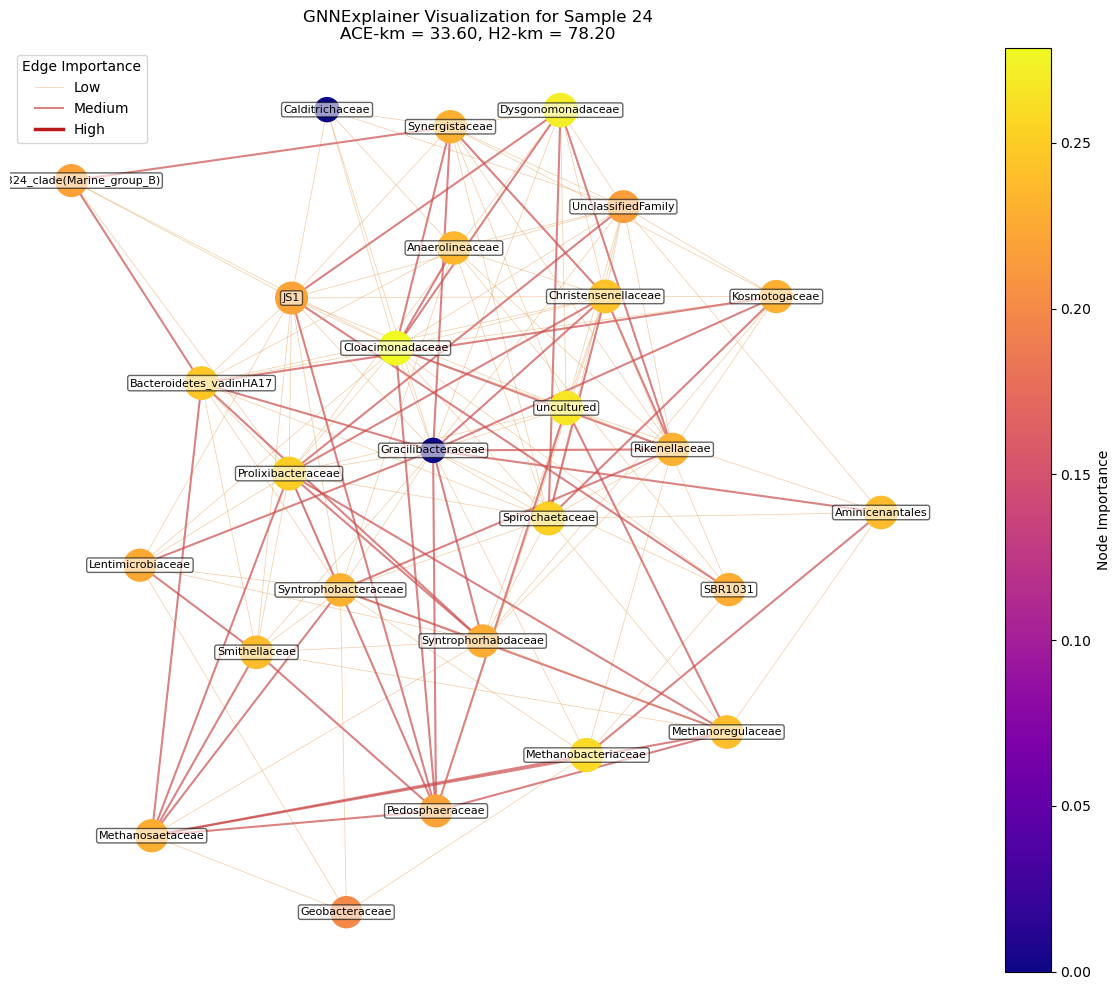

           Microbial_Family  Importance
9          Cloacimonadaceae    0.278707
1         Dysgonomonadaceae    0.271091
2                uncultured    0.265702
0       Methanobacteriaceae    0.258521
6           Spirochaetaceae    0.251605
18       Prolixibacteraceae    0.250504
15  Bacteroidetes_vadinHA17    0.245127
20      Christensenellaceae    0.243738
21        Methanoregulaceae    0.238767
10            Smithellaceae    0.238202


In [78]:
import torch_geometric
import torch
import numpy as np
import random
import matplotlib.lines as mlines
import networkx as nx
import matplotlib.pyplot as plt
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

from torch_geometric.explain import GNNExplainer, Explainer
import torch.nn as nn
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set all random seeds for reproducibility
seed = 42  # Use the same seed as the sample visualization
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a wrapper for your model to make it compatible with the explainer
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x, edge_index, batch=None):
        # Create a Data-like object that your model expects
        class DataContainer:
            pass
        
        data = DataContainer()
        data.x = x
        data.edge_index = edge_index
        data.batch = batch
        
        return self.model(data)

# Wrap your model and ensure it's in eval mode
model.eval()
# Disable dropout for consistency
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0
wrapped_model = ModelWrapper(model)

sample_idx = 24
sample = graphs[sample_idx].to(device)

# Create a batch tensor (since we're only explaining one sample)
if sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=device)

# Important: Make sure tensors require grad for the explainer
x = sample.x.clone().detach().requires_grad_(True)
edge_index = sample.edge_index.clone().detach()

# Create the explainer with deterministic settings
torch.manual_seed(seed)  # Set seed again before creating explainer
algorithm = GNNExplainer(epochs=200)
explainer = Explainer(
    model=wrapped_model,  # Use the wrapped model
    algorithm=algorithm,
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    )
)

# Generate the explanation WITH deterministic settings
torch.manual_seed(seed)  # Set seed again before explanation
explanation = explainer(x, edge_index, batch=sample.batch)
node_feat_mask = explanation.node_mask
edge_mask = explanation.edge_mask
edge_mask_np = edge_mask.cpu().numpy()

print(f"Explaining prediction for Sample {sample_idx}")
print(f"Target values: ACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")

# Print the top 5 most important nodes
node_importance = node_feat_mask.squeeze().cpu().numpy()
top_node_indices = node_importance.argsort()[-5:][::-1]
print("\nTop 5 most important microbial families for this prediction:")
for i, idx in enumerate(top_node_indices):
    print(f"{i+1}. {node_feature_names[idx]} (importance: {node_importance[idx]:.3f})")

# ===============================================================================
# GRAPH VISUALIZATION - EXACTLY matching the approach from the sample visualization
# ===============================================================================

# Get the original edge_index from when the graph was first created
original_edge_index = edge_index  # This should be the global edge_index used to create all graphs

# Create a copy of the ORIGINAL static graph G 
H = nx.Graph()

# Add all nodes first
for i, name in enumerate(node_feature_names):
    # Use node importance from GNNExplainer instead of abundance
    H.add_node(name, importance=float(node_feat_mask[i].cpu()))

# Add ALL edges from the original edge structure
for i in range(original_edge_index.shape[1]):
    src = int(original_edge_index[0, i])
    dst = int(original_edge_index[1, i])
    # Add all edges with default minimal weight
    H.add_edge(node_feature_names[src], node_feature_names[dst], weight=0.01)

# Now update edge weights from GNNExplainer results
for i in range(edge_mask.shape[0]):
    src = int(sample.edge_index[0, i].cpu())
    dst = int(sample.edge_index[1, i].cpu())
    src_name = node_feature_names[src]
    dst_name = node_feature_names[dst]
    # Update edge weights for edges identified by GNNExplainer
    H[src_name][dst_name]['weight'] = float(edge_mask_np[i])
    
# Use the same layout algorithm with the same seed
random.seed(seed)
pos = nx.kamada_kawai_layout(H)

# Create visualization
plt.figure(figsize=(12, 10))

# Create edge style mappings
edge_weights = []
edge_colors = []
edge_widths = []
edge_alphas = []

# Normalize edge weights for coloring
edge_min = min([H[u][v]['weight'] for u,v in H.edges()])
edge_max = max([H[u][v]['weight'] for u,v in H.edges()])
print(f"Edge weight range: {edge_min:.3f} to {edge_max:.3f}")

# Define specific colors for each importance level
LOW_COLOR = (0.9, 0.6, 0.3, 0.5)    # Light orange with 50% opacity
MED_COLOR = (0.8, 0.3, 0.3, 0.7)    # Medium red with 70% opacity
HIGH_COLOR = (0.7, 0.0, 0.0, 0.9)   # Dark red with 90% opacity

# Prepare edge styling with fixed colors by category
for u, v in H.edges():
    weight = H[u][v]['weight']
    edge_weights.append(weight)
    
    # Edge width and alpha based on importance categories: Low, Medium, High
    if weight <= 0.1:
        width = 0.5  # Low importance
        color = LOW_COLOR
    elif weight <= 0.3:
        width = 1.5  # Medium importance
        color = MED_COLOR
    else:
        width = 2.5  # High importance
        color = HIGH_COLOR
        
    edge_widths.append(width)
    edge_colors.append(color)

# Draw edges with styling based on importance
for i, (u, v) in enumerate(H.edges()):
    nx.draw_networkx_edges(H, pos, edgelist=[(u, v)], 
                          width=edge_widths[i], 
                          edge_color=[edge_colors[i]])

# Draw nodes (sized and colored by importance)
node_sizes = [300 + 1000 * H.nodes[n]['importance'] for n in H.nodes()]
node_colors = [H.nodes[n]['importance'] for n in H.nodes()]

nodes = nx.draw_networkx_nodes(
    H, pos, 
    node_size=node_sizes,
    node_color=node_colors, 
    cmap=plt.cm.plasma
)

# Add node labels
nx.draw_networkx_labels(H, pos, labels={n: n for n in H.nodes()}, font_size=8,
                       bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.6))

# Add a custom legend for edge importance - only Low, Medium, High
handles = []
importance_labels = ['Low', 'Medium', 'High']
colors = [LOW_COLOR, MED_COLOR, HIGH_COLOR]
widths = [0.5, 1.5, 2.5]

for label, color, width in zip(importance_labels, colors, widths):
    handles.append(mlines.Line2D([], [], color=color, linewidth=width, 
                               label=f'{label}'))

plt.legend(handles=handles, title="Edge Importance", loc='upper left')

# Add colorbar and title
plt.colorbar(nodes, label="Node Importance")
plt.title(f"GNNExplainer Visualization for Sample {sample_idx}\nACE-km = {float(sample.y[0, 0]):.2f}, H2-km = {float(sample.y[0, 1]):.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the explanation results if needed
import pandas as pd
importance_df = pd.DataFrame({
    'Microbial_Family': node_feature_names,
    'Importance': node_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df.head(10))  # Print top 10 important features

# Optional: Save explanation results to file for future use
torch.save({
    'node_importance': node_feat_mask,
    'edge_mask': edge_mask,
    'sample_idx': sample_idx
}, f'gnnexplainer_results_sample_{sample_idx}.pt') 